<a href="https://colab.research.google.com/github/raktim711/AIMS-project---Anomaly-Detection/blob/main/davidc_hlt_studies_20251119_duplicates_OR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HLT Studies Nov 2025: Duplicates & Overlap Removal

__Author:__ Claire David  
__Date created:__ Nov 6, 2025  
__Goals:__
* Inspect duplicated objects in events
* Perform overlap removal as data cleaning/preprocess

__Subgoals:__
* Get new utils functions for a new repo

__Status:__  
* Duplicate removal works (need to tidy up)
* Need to code the Overlap Removal




In [1]:
import os

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

from math import sqrt, pi

from collections import defaultdict

## Mount GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Repository
Shortcut in Claire's Drive pointing to Raktim's repo:

In [3]:
repo='/content/drive/MyDrive/Datasets/ADdata'
!ls $repo

EB25_500306.h5
MC_ggF_H125_a16a16_4b_ctau10_filtered_470000.h5
MC_HAHMggf_470000.h5
MC_hh_bbbb_vbf_novhh_5fs_l1cvv1cv1_470000.h5
MC_HNLeemu_470000.h5
MC_HtoSUEP_470000.h5
MC_VBF_H125_a55a55_4b_ctau1_filtered_470000.h5
MC_Znunu_470000.h5


## Load Inputs
To put in future `utils/load_inputs.py`

In [4]:
def load_and_preprocess_datasets(base_dir):
    """
    Load all HDF5 files from a base directory and preprocess them into a
    standardized dataset dictionary.

    Steps performed:
    1. Load every .h5 file and store each file under a dataset tag.
    2. Remove EB24 samples.
    3. Rename EB25 sample to 'EB_test'.
    4. Convert trigger flags (HLT/L1) to boolean arrays.
    5. For MC samples:
         - add unit event weights
         - standardize tag names (strip MC_... parts)

    Args:
        base_dir (str): Path to the folder containing all HDF5 files.

    Returns:
        dict: A dictionary mapping dataset tags → dict of numpy arrays.
    """


    datasets = {} # dictionary of dictionaries, each dictionary is a dataset

    # ====== 1. Load the data ======
    # loop over all the files in the base directory
    for tag in os.listdir(base_dir):
        file_path = os.path.join(base_dir, tag)
        datasets[tag] = {}

        # load the data from the file
        with h5py.File(file_path, 'r') as hf:
            for key in hf.keys():
                datasets[tag][key] = hf[key][:]

    # ====== 2. Remove EB24 samples ======
    for tag in list(datasets.keys()):
        if tag.startswith("EB24"):
            del datasets[tag]

    # ====== 3. Rename EB25 to EB_test ======
    if "EB25_500306.h5" in datasets:
        datasets["EB_test"] = datasets.pop("EB25_500306.h5")

    # ====== 4. Convert trigger flags ======
    for tag, d in datasets.items():
        d["passHLT"] = (d["pass_HLT_unprescaled"] == 1)
        d["passL1"]  = (d["pass_L1_unprescaled"] == 1)
        del d["pass_HLT_unprescaled"]
        del d["pass_L1_unprescaled"]

    # ====== 5. Add MC weights ======
    for tag, d in datasets.items():
        if tag.startswith("MC"):
            d["weights"] = np.ones(len(d["run_numbers"]))

    # ====== 6. Normalize MC tag names ======
    original_tags = list(datasets.keys())

    for tag in original_tags:
        if tag.startswith("MC"):
            new_tag = tag.split("MC_")[1]
            new_tag = new_tag.split("_470000")[0]

            if new_tag == "hh":
                new_tag = "hh_bbbb_vbf_novhh_5fs_l1cvv1cv1"

            datasets[new_tag] = datasets.pop(tag)

    # ====== Sanity check ======
    total_events = sum(len(next(iter(d.values()))) for d in datasets.values())

    total_bytes = 0
    for d in datasets.values():
        for arr in d.values():
            total_bytes += arr.nbytes

    total_gb = total_bytes / (1024**3)

    print(f"[load_and_preprocess_datasets] Loaded {len(datasets)} datasets "
          f"({total_events:,} total events, ~{total_gb:.2f} GB)")

    return datasets


In [5]:
def print_shapes(datasets, tags=None):
    """
    Print the detailed shapes of arrays in selected datasets.

    Args:
        datasets (dict): Dictionary {tag -> dict of arrays}.
        tags (list or None): List of dataset tags to print. If None, print all.
    """
    if tags is None:
        tags = datasets.keys()

    for tag in tags:
        print(f"{tag}:")
        data_dict = datasets[tag]
        for key, value in data_dict.items():
            print(f"  {key}: {value.shape}")
        print()

In [6]:
datasets = load_and_preprocess_datasets(repo)

[load_and_preprocess_datasets] Loaded 8 datasets (1,487,586 total events, ~1.25 GB)


In [7]:
hlt_data_tags = [t for t in datasets if not t.startswith("MC")]
print("HLT data tags:")
for tag in hlt_data_tags:
    print(f" - {tag}")

HLT data tags:
 - EB_test
 - HAHMggf
 - HNLeemu
 - HtoSUEP
 - VBF_H125_a55a55_4b_ctau1_filtered
 - Znunu
 - ggF_H125_a16a16_4b_ctau10_filtered
 - hh_bbbb_vbf_novhh_5fs_l1cvv1cv1


In [8]:
hlt_data_all_tags = [t for t in datasets]
print("HLT data all tags:")
for tag in hlt_data_all_tags:
    print(f" - {tag}")

HLT data all tags:
 - EB_test
 - HAHMggf
 - HNLeemu
 - HtoSUEP
 - VBF_H125_a55a55_4b_ctau1_filtered
 - Znunu
 - ggF_H125_a16a16_4b_ctau10_filtered
 - hh_bbbb_vbf_novhh_5fs_l1cvv1cv1


In [9]:
print_shapes(datasets, ['EB_test', 'HAHMggf', 'HtoSUEP','Znunu'])

EB_test:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_L1AD: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
  passHLT: (1017586,)
  passL1: (1017586,)

HAHMggf:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_online: (100000,)
  passL1ADT_online: (100000,)
 

In [10]:
def build_dataframe(datasets, tags=None):
    """
    Build a combined HLT dataframe with weights and target labels.

    Args:
        datasets (dict): {tag -> dict of arrays}
        tags (list or None): list of tags to include; default = all

    Returns:
        pd.DataFrame: combined dataframe
    """
    if tags is None:
        tags = datasets.keys()

    # Hardcoded HLT_data column names
    columns = [
        'j0pt','j0eta','j0phi','j1pt','j1eta','j1phi',
        'j2pt','j2eta','j2phi','j3pt','j3eta','j3phi',
        'j4pt','j4eta','j4phi','j5pt','j5eta','j5phi',
        'e0pt','e0eta','e0phi','e1pt','e1eta','e1phi',
        'e2pt','e2eta','e2phi',
        'mu0pt','mu0eta','mu0phi','mu1pt','mu1eta','mu1phi',
        'mu2pt','mu2eta','mu2phi',
        'ph0pt','ph0eta','ph0phi','ph1pt','ph1eta','ph1phi',
        'ph2pt','ph2eta','ph2phi',
        'METpt','METeta','METphi'
    ]

    dfs = []
    for tag in tags:
        d = datasets[tag]
        df = pd.DataFrame(d['HLT_data'], columns=columns)

        # Event and run numbers:
        df['run_number'] = d['run_numbers']
        df['event_number'] = d['event_numbers']

        # Weights:
        df['weight'] = np.asarray(d['weights']).reshape(-1)
        df['target'] = tag

        # HLTAD scores:
        if 'HLT_AD_scores' in d:
            df['HLT_AD_scores'] = np

        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [11]:
hlt_df = build_dataframe(datasets)

In [12]:
hlt_df.head()

,j0pt,j0eta,j0phi,j1pt,j1eta,j1phi,j2pt,j2eta,j2phi,j3pt,...,ph2pt,ph2eta,ph2phi,METpt,METeta,METphi,run_number,event_number,weight,target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.009135,0.0,-1.915390,500306,1027130115,5.0,EB_test
1,23.893738,-0.032734,1.230678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.742011,0.0,-1.910914,500306,1027130405,5.0,EB_test
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,500306,1027120493,12.0,EB_test
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.936713,0.0,-0.541381,500306,1027150997,12.0,EB_test
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,500306,1027146367,5.0,EB_test


In [13]:
# To know the indices:
prev = None
for idx, tgt in hlt_df['target'].items():
    if tgt != prev:
        print(f"{idx:10d}   {tgt}")
        prev = tgt

         0   EB_test
   1017586   HAHMggf
   1117586   HNLeemu
   1217586   HtoSUEP
   1317586   VBF_H125_a55a55_4b_ctau1_filtered
   1417586   Znunu
   1427586   ggF_H125_a16a16_4b_ctau10_filtered
   1437586   hh_bbbb_vbf_novhh_5fs_l1cvv1cv1


## Event Display (Transverse View)

In [14]:
plt.rcParams.update({

    # Legend
    'legend.frameon': False,

    # Ticks
    'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 10,
        'ytick.major.size': 10,
        'xtick.minor.size': 5,
        'ytick.minor.size': 5,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.top': True,
        'ytick.right': True,
        'xtick.minor.visible': True,
        'ytick.minor.visible': True
})

In [15]:
def plot_event_2D(df, tag, event_idx):
    """
    Plot physics objects as 2D vectors in the transverse plane for a given event.
    Works with a combined dataframe that contains a 'target' column.

    Args:
        df (pd.DataFrame): combined HLT dataframe with 'target' and 'weight' columns.
        event_idx (int): index of the event within the selected dataset.
        tag (str): dataset tag to select (required).

    Returns:
        fig, ax: matplotlib figure and axes
    """
    # Filter dataframe by the selected tag
    df_tag = df[df['target'] == tag].reset_index(drop=True)

    if df_tag.empty:
        raise ValueError(f"Event ID not found for tag '{tag}'")

    df_event = df_tag.loc[event_idx]  # safe to use now

    fig, ax = plt.subplots(figsize=(6, 6), dpi=180)

    # Object types and indices
    obj_map = {
        'j': 5,   # jets: 0-5
        'e': 2,   # electrons: 0-2
        'mu': 2,  # muons: 0-2
        'ph': 2   # photons: 0-2
    }

    obj_styles = {
        'j': {'color': 'royalblue', 'label': 'Jets', 'width': 0.003},
        'e': {'color': 'red', 'label': 'Electrons', 'width': 0.003},
        'mu': {'color': 'green', 'label': 'Muons', 'width': 0.003},
        'ph': {'color': 'orange', 'label': 'Photons', 'width': 0.003},
        'MET': {'color': 'black', 'label': 'MET', 'width': 0.005}
    }

    max_pt = 0
    legend_elements = []  # Store legend entries
    groups_seen = set() # To add blank line after a particle type

    # --- Legend header + skip line ---
    leg_header = (
            f"Run Number: {df_event['run_number']}  |  "
            f"Event Number: {df_event['event_number']}"
        )
    legend_elements.append(
        plt.Line2D([0], [0], linestyle='', label=leg_header)
    )
    legend_elements.append(plt.Line2D([0], [0], linestyle='', alpha=0, label=''))

    # --- Plot particles ---
    for prefix, max_idx in obj_map.items():
        style = obj_styles[prefix]
        object_info = []

        for i in range(max_idx + 1):
            pt_col  = f'{prefix}{i}pt'
            eta_col = f'{prefix}{i}eta'
            phi_col = f'{prefix}{i}phi'

            if pt_col not in df.columns or phi_col not in df.columns or eta_col not in df.columns:
                continue

            pt  = df_event[pt_col]
            eta = df_event[eta_col]
            phi = df_event[phi_col]

            if pt <= 0.001:
                continue

            object_info.append((pt, eta, phi))
            max_pt = max(max_pt, pt)

            x = pt * np.cos(phi)
            y = pt * np.sin(phi)
            ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1,
                      color=style['color'], width=style['width'])

        if object_info:

            if groups_seen: # new particle type: blank line before
                legend_elements.append(
                    plt.Line2D([0], [0], linestyle='', alpha=0, label='')
                )
            groups_seen.add(prefix)

            # Add group title (Jets / Electrons / Muons / Photons)
            legend_elements.append(
                plt.Line2D([0], [0], color=style['color'], label=style['label'])
            )

            for pt, eta, phi in sorted(object_info, reverse=True):
                legend_elements.append(
                    plt.Line2D(
                        [0], [0], color=style['color'], linestyle='',
                        label = (
                            fr'$p_T$ = {pt:<6.1f}    '
                            fr'$\eta$ = {eta:<6.3f}    '
                            fr'$\phi$ = {phi:<6.3f}'
                        )
                    )
                )

    # --- MET ---
    if 'METpt' in df.columns and df_event['METpt'] > 0.001:
        pt, phi = df_event['METpt'], df_event['METphi']
        max_pt = max(max_pt, pt)
        style = obj_styles['MET']
        x = pt * np.cos(phi)
        y = pt * np.sin(phi)
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1,
                  color=style['color'], width=style['width'])

        legend_elements.append(plt.Line2D([0], [0], linestyle='', alpha=0, label=''))
        legend_elements.append(
            plt.Line2D([0], [0], color=style['color'], label=style['label'])
        )
        legend_elements.append(
            plt.Line2D([0], [0], color=style['color'], linestyle='',
                       label = fr'$p_T$ = {pt:<6.1f}    $\phi$ = {phi:<6.3f}'
            )
        )

    # --- Plot settings ---
    ax.set_aspect('equal', adjustable='box')
    limit = max_pt * 1.2
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # ax.grid(True, linestyle='--', alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.2)

    # Add circular guidelines with round numbers
    max_radius = int(np.ceil(max_pt))
    step = 20 if max_radius > 100 else 10
    circles = np.arange(step, max_radius + step, step)  # Create array of round numbers

    for radius in circles:
        circle = plt.Circle((0, 0), radius, fill=False, linestyle='--',
                          alpha=0.2, color='gray')
        ax.add_artist(circle)
        ax.text(radius*np.cos(np.pi/4), radius*np.sin(np.pi/4),
                f'{radius:.0f} GeV', fontsize=8, alpha=0.5)

    ax.set_xlabel(r'$p_T \,\cos(\phi)$ [GeV]')
    ax.set_ylabel(r'$p_T \,\sin(\phi)$ [GeV]')
    ax.set_title("Transverse View")

    plt.tight_layout()
    legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1.06, 1.05), loc='upper left')
    legend.get_texts()[0].set_fontsize(12)   # header only bigger

    plt.subplots_adjust(right=0.75)

    return fig, ax

## Event Dump

In [16]:
def print_event_ordered(df, tag, event_idx=None, run_number=None, event_number=None):
    """
    Print event information either by df index or by (run_number, event_number).

    Exactly one of the following must be provided:
      - event_idx
      - run_number + event_number
    """
    # Filter by tag
    df_tag = df[df['target'] == tag].reset_index(drop=True)
    if df_tag.empty:
        print(f"No events found for tag '{tag}'")
        return

    # --- argument validation ---
    if event_idx is not None and (run_number is not None or event_number is not None):
        raise ValueError("Provide EITHER event_idx OR (run_number + event_number), not both.")

    if event_idx is None and (run_number is None or event_number is None):
        raise ValueError("Provide either event_idx OR both run_number and event_number.")

    # --- select by event_idx ---
    if event_idx is not None:
        df_event = df_tag.iloc[event_idx]

        print(f"Selected by event_idx = {event_idx}")
        print(f"Run Number   = {df_event['run_number']}")
        print(f"Event Number = {df_event['event_number']}")

    else:
        # --- select by run_number + event_number ---
        mask = (
            (df_tag['run_number'] == run_number) &
             (df_tag['event_number'] == event_number)
        )
        matches = df_tag[mask]

        if len(matches) == 0:
            raise ValueError(
                f"No event found with run_number={run_number} and event_number={event_number}."
            )
        elif len(matches) > 1:
            print("Warning: multiple matches — unexpected.")

        df_event = matches.iloc[0]

        print(f"Selected by run_number={run_number}, event_number={event_number}")
        print(f"  df index     = {df_event.name}")

    # Define object type order
    obj_order = ['j', 'e', 'mu', 'ph', 'MET']

    # Gather all pt columns by object type
    pt_cols_by_type = {obj: [] for obj in obj_order}

    for col in df_tag.columns:
        if col.endswith('pt'):
            base = col[:-2]
            for obj in obj_order:
                if base.startswith(obj):
                    pt_cols_by_type[obj].append(col)
                    break
            else:
                # catch any other object types if needed
                pass

    # Print header
    print(f"\nDataset {tag}, Event {event_idx}:")
    print("-" * 55)
    print(f"{'Object':<15} {'pT [GeV]':>10} {'η':>10} {'φ':>10}")
    print("-" * 55)

    # Loop over object types in order
    for obj in obj_order:
        for pt_col in sorted(pt_cols_by_type[obj]):
            base_name = pt_col[:-2]
            eta_col = base_name + 'eta'
            phi_col = base_name + 'phi'

            pt = df_event[pt_col]
            eta = df_event[eta_col] if eta_col in df_tag.columns else float('nan')
            phi = df_event[phi_col] if phi_col in df_tag.columns else float('nan')

            # Skip near-zero pT objects
            # if pt <= 0.001 and obj != 'MET':
            #     continue

            print(f"{base_name:<15} {pt:>10.1f} {eta:>10.3f} {phi:>10.3f}")

    print("-" * 55)

    # Optional: print weight / score
    if 'weights' in df_tag.columns:
        print(f"Event weight: {df_event['weights']:.3f}")
    if 'HLT_AD_scores' in df_tag.columns:
        print(f"HLT AD score: {df_event['HLT_AD_scores']:.1f}")


## Checking events

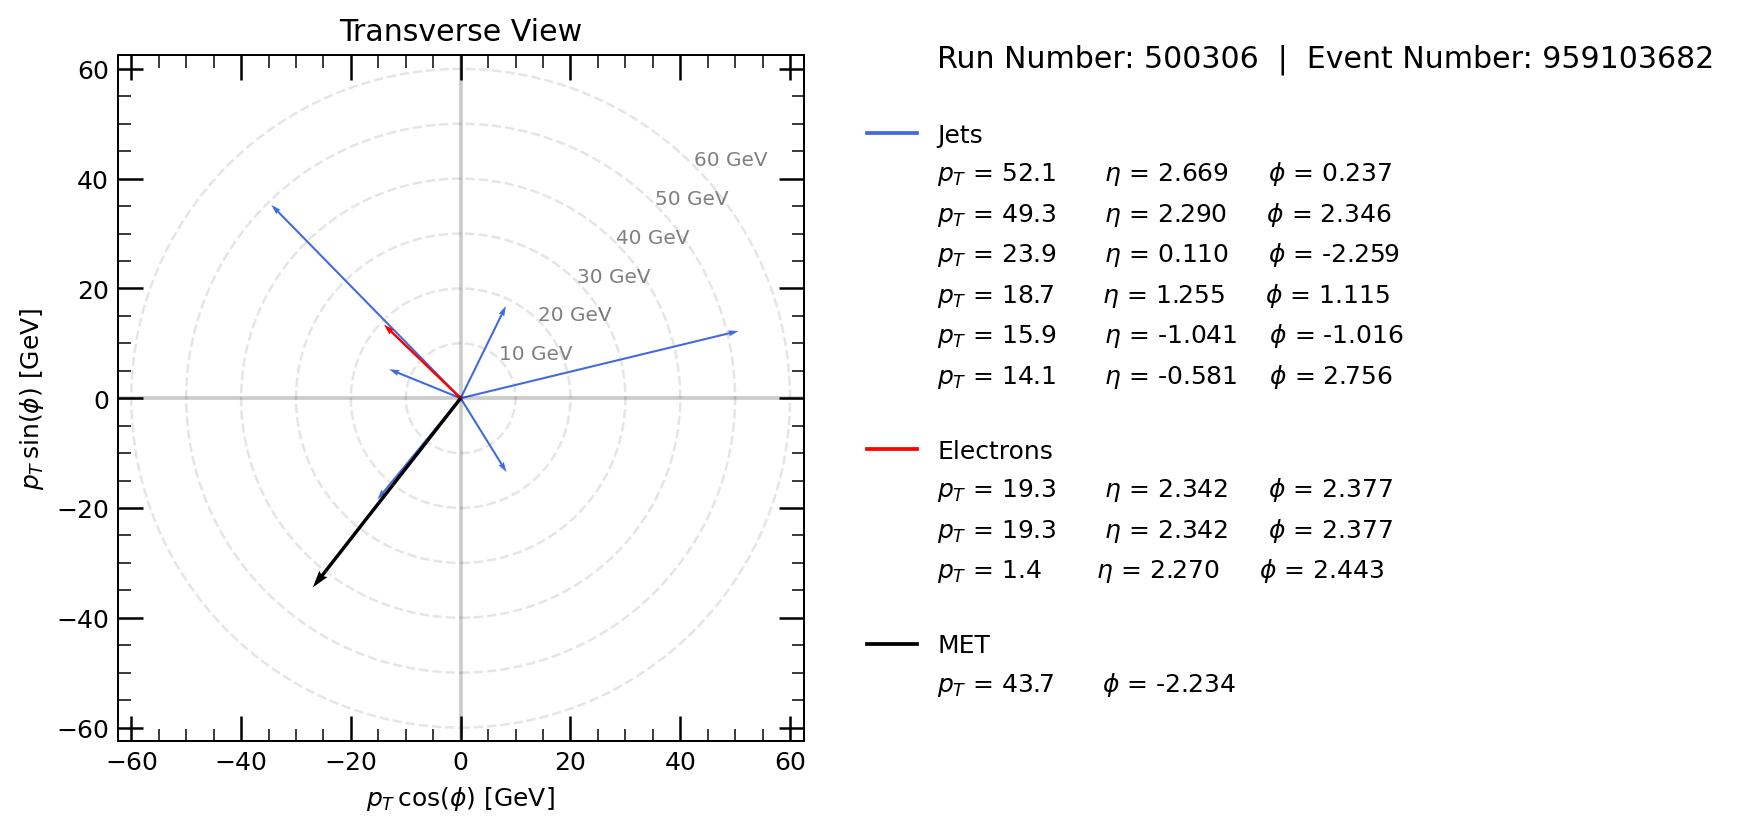

In [17]:
fix, ax = plot_event_2D(hlt_df, 'EB_test', event_idx=10123)

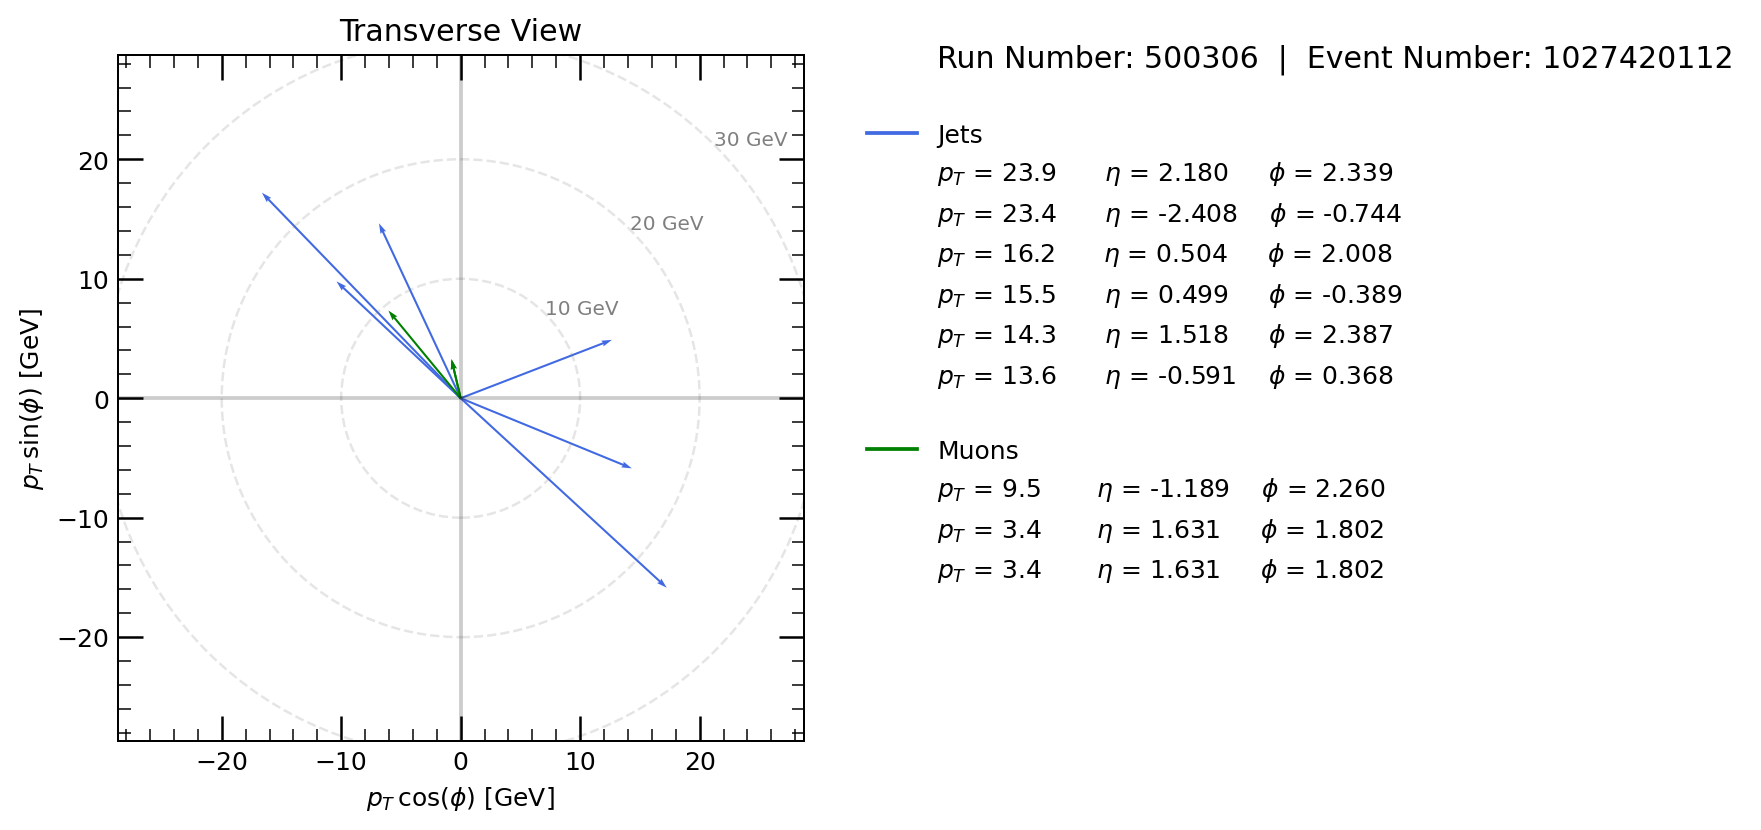

In [18]:
fix, ax = plot_event_2D(hlt_df, 'EB_test', event_idx=101)

## Duplicate Removal

In [19]:
def remove_duplicates_per_event(df, tag):
    """
    Remove duplicate physics objects in each event for a given tag
    Shift remaining objects up (zero padded)

    Args:
        df (pd.DataFrame): original dataframe with all events
        tag (str): value of the 'target' column to select events

    Returns:
        df_cleaned (pd.DataFrame): cleaned dataframe with duplicates removed
    """
    # --- Configuration ---
    obj_map = {'j':5, 'e':2, 'mu':2, 'ph':2}  # max indices
    obj_types = obj_map.keys()

    # Filter dataframe by tag
    df_clean = df[df['target'] == tag].copy().reset_index(drop=True)

    if df_clean.empty:
        raise ValueError(f"No events found for tag '{tag}'")

    # Prepare counters
    events_with_duplicates = defaultdict(int)
    raw_count = defaultdict(int)
    unique_count = defaultdict(int)

    # Iterate over events
    for idx, row in df_clean.iterrows():

        # --- Progress indicator ---
        if idx % 20000 == 0:
            print(f"Processing event {idx+1:,} / {len(df_clean):,} ...")

        for obj in obj_types:
            max_idx = obj_map[obj]

            # Collect current object values
            objs = []
            for i in range(max_idx + 1):
                pt = row[f'{obj}{i}pt']
                eta = row[f'{obj}{i}eta']
                phi = row[f'{obj}{i}phi']
                objs.append((pt, eta, phi))

            # Count raw
            raw_count[obj] += sum(1 for o in objs if o != (0.0, 0.0, 0.0))

            # Identify duplicates (keep first occurrence)
            seen = set()
            unique_objs = []
            duplicates_found = False
            for o in objs:
                if o == (0.0, 0.0, 0.0):
                    continue  # skip zero objects entirely
                if o in seen:
                    duplicates_found = True
                    continue
                seen.add(o)
                unique_objs.append(o)

            if duplicates_found:
                events_with_duplicates[obj] += 1

            unique_count[obj] += len(unique_objs)

            # Shift objects up and pad with zeros
            padded_objs = unique_objs + [(0.0, 0.0, 0.0)] * (len(objs) - len(unique_objs))

            # Write back to dataframe
            for i, (pt, eta, phi) in enumerate(padded_objs):
                df_clean.at[idx, f'{obj}{i}pt'] = pt
                df_clean.at[idx, f'{obj}{i}eta'] = eta
                df_clean.at[idx, f'{obj}{i}phi'] = phi

    # --- Summary ---
    total_events = len(df_clean)
    print(f"\nDataset {tag}, {total_events:,} events total\n")

    print(f"{'Object':<12} {'# raw':>12} {'# unique':>12} {'# duplicates':>14} {'% duplicates':>14}")
    print("-" * 70)

    for obj in obj_types:
        raw = raw_count[obj]
        unique = unique_count[obj]
        dup_removed = raw - unique
        perc = (dup_removed / raw * 100) if raw > 0 else 0.0

        print(
            f"{obj:<12}"
            f"{raw:>12,}"
            f"{unique:>12,}"
            f"{dup_removed:>14,}"
            f"{perc:>13.1f}%"
        )

    return df_clean


In [20]:
hlt_df_no_dupl = {}
hlt_df_no_dupl['HAHMggf'] = remove_duplicates_per_event(hlt_df, 'HAHMggf')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HAHMggf, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                571,435     571,435             0          0.0%
e                196,043     129,771        66,272         33.8%
mu                81,373      78,174         3,199          3.9%
ph               168,141     111,939        56,202         33.4%


In [21]:
hlt_df_no_dupl['HNLeemu'] = remove_duplicates_per_event(hlt_df, 'HNLeemu')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HNLeemu, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                570,261     570,261             0          0.0%
e                208,719     132,400        76,319         36.6%
mu                42,071      39,879         2,192          5.2%
ph               196,748     125,688        71,060         36.1%


In [22]:
hlt_df_no_dupl['HtoSUEP'] = remove_duplicates_per_event(hlt_df, 'HtoSUEP')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HtoSUEP, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                582,127     582,127             0          0.0%
e                132,716     117,140        15,576         11.7%
mu                 4,555       4,154           401          8.8%
ph                40,842      39,792         1,050          2.6%


In [23]:
hlt_df_no_dupl['VBF_H125_a55a55_4b_ctau1_filtered'] = remove_duplicates_per_event(hlt_df, 'VBF_H125_a55a55_4b_ctau1_filtered')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset VBF_H125_a55a55_4b_ctau1_filtered, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                594,731     594,731             0          0.0%
e                251,421     201,108        50,313         20.0%
mu                36,433      34,276         2,157          5.9%
ph                61,312      57,340         3,972          6.5%


In [24]:
hlt_df_no_dupl['Znunu'] = remove_duplicates_per_event(hlt_df, 'Znunu')

Processing event 1 / 10,000 ...

Dataset Znunu, 10,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                 58,627      58,627             0          0.0%
e                 25,659      19,705         5,954         23.2%
mu                 2,445       2,266           179          7.3%
ph                 5,108       4,759           349          6.8%


In [25]:
hlt_df_no_dupl['ggF_H125_a16a16_4b_ctau10_filtered'] = remove_duplicates_per_event(hlt_df, 'ggF_H125_a16a16_4b_ctau10_filtered')

Processing event 1 / 10,000 ...

Dataset ggF_H125_a16a16_4b_ctau10_filtered, 10,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                 59,220      59,220             0          0.0%
e                 29,259      20,825         8,434         28.8%
mu                 4,818       4,148           670         13.9%
ph                 5,990       5,496           494          8.2%


In [26]:
hlt_df_no_dupl['hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'] = remove_duplicates_per_event(hlt_df, 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1')

Processing event 1 / 50,000 ...
Processing event 20,001 / 50,000 ...
Processing event 40,001 / 50,000 ...

Dataset hh_bbbb_vbf_novhh_5fs_l1cvv1cv1, 50,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                299,333     299,333             0          0.0%
e                143,997     111,207        32,790         22.8%
mu                25,114      23,581         1,533          6.1%
ph                34,265      31,363         2,902          8.5%


In [27]:
hlt_df_no_dupl['EB_test'] = remove_duplicates_per_event(hlt_df, 'EB_test')

Processing event 1 / 1,017,586 ...
Processing event 20,001 / 1,017,586 ...
Processing event 40,001 / 1,017,586 ...
Processing event 60,001 / 1,017,586 ...
Processing event 80,001 / 1,017,586 ...
Processing event 100,001 / 1,017,586 ...
Processing event 120,001 / 1,017,586 ...
Processing event 140,001 / 1,017,586 ...
Processing event 160,001 / 1,017,586 ...
Processing event 180,001 / 1,017,586 ...
Processing event 200,001 / 1,017,586 ...
Processing event 220,001 / 1,017,586 ...
Processing event 240,001 / 1,017,586 ...
Processing event 260,001 / 1,017,586 ...
Processing event 280,001 / 1,017,586 ...
Processing event 300,001 / 1,017,586 ...
Processing event 320,001 / 1,017,586 ...
Processing event 340,001 / 1,017,586 ...
Processing event 360,001 / 1,017,586 ...
Processing event 380,001 / 1,017,586 ...
Processing event 400,001 / 1,017,586 ...
Processing event 420,001 / 1,017,586 ...
Processing event 440,001 / 1,017,586 ...
Processing event 460,001 / 1,017,586 ...
Processing event 480,001 /

In [28]:
print_event_ordered(hlt_df, tag='EB_test', event_idx=101)

Selected by event_idx = 101
Run Number   = 500306
Event Number = 1027420112

Dataset EB_test, Event 101:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    23.9      2.180      2.339
j1                    23.4     -2.408     -0.744
j2                    16.2      0.504      2.008
j3                    15.5      0.499     -0.389
j4                    14.3      1.518      2.387
j5                    13.6     -0.591      0.368
e0                     0.0      0.000      0.000
e1                     0.0      0.000      0.000
e2                     0.0      0.000      0.000
mu0                    9.5     -1.189      2.260
mu1                    3.4      1.631      1.802
mu2                    3.4      1.631      1.802
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.000

In [29]:
print_event_ordered(hlt_df_no_dupl['EB_test'], tag='EB_test', event_idx=101)

Selected by event_idx = 101
Run Number   = 500306
Event Number = 1027420112

Dataset EB_test, Event 101:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    23.9      2.180      2.339
j1                    23.4     -2.408     -0.744
j2                    16.2      0.504      2.008
j3                    15.5      0.499     -0.389
j4                    14.3      1.518      2.387
j5                    13.6     -0.591      0.368
e0                     0.0      0.000      0.000
e1                     0.0      0.000      0.000
e2                     0.0      0.000      0.000
mu0                    9.5     -1.189      2.260
mu1                    3.4      1.631      1.802
mu2                    0.0      0.000      0.000
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.000

In [30]:
print_event_ordered(hlt_df, tag='EB_test', event_idx=10123)

Selected by event_idx = 10123
Run Number   = 500306
Event Number = 959103682

Dataset EB_test, Event 10123:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    52.1      2.669      0.237
j1                    49.3      2.290      2.346
j2                    23.9      0.110     -2.259
j3                    18.7      1.255      1.115
j4                    15.9     -1.041     -1.016
j5                    14.1     -0.581      2.756
e0                    19.3      2.342      2.377
e1                    19.3      2.342      2.377
e2                     1.4      2.270      2.443
mu0                    0.0      0.000      0.000
mu1                    0.0      0.000      0.000
mu2                    0.0      0.000      0.000
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.

In [31]:
print_event_ordered(hlt_df_no_dupl['EB_test'], tag='EB_test', event_idx=10123)

Selected by event_idx = 10123
Run Number   = 500306
Event Number = 959103682

Dataset EB_test, Event 10123:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    52.1      2.669      0.237
j1                    49.3      2.290      2.346
j2                    23.9      0.110     -2.259
j3                    18.7      1.255      1.115
j4                    15.9     -1.041     -1.016
j5                    14.1     -0.581      2.756
e0                    19.3      2.342      2.377
e1                     1.4      2.270      2.443
e2                     0.0      0.000      0.000
mu0                    0.0      0.000      0.000
mu1                    0.0      0.000      0.000
mu2                    0.0      0.000      0.000
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.

 - HAHMggf
 - HNLeemu
 - HtoSUEP
 - VBF_H125_a55a55_4b_ctau1_filtered
 - Znunu
 - ggF_H125_a16a16_4b_ctau10_filtered
 - hh_bbbb_vbf_novhh_5fs_l1cvv1cv1

## Concatenate All After Duplicate Removal

In [32]:
order = [
    'EB_test',
    'HAHMggf',
    'HNLeemu',
    'HtoSUEP',
    'VBF_H125_a55a55_4b_ctau1_filtered',
    'Znunu',
    'ggF_H125_a16a16_4b_ctau10_filtered',
    'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'
]

hlt_df_no_dupl_concat = pd.concat(
    [hlt_df_no_dupl[tag] for tag in order],
    axis=0
)

hlt_df_no_dupl_concat.index = hlt_df.index

## Overlap Removal

In [33]:
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def delta_r(eta1, phi1, eta2, phi2):
    return sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)


def overlap_removal(df, tag):
    """
    Perform Overlap Removal (OR) using ONLY the rules allowed by the dataset.
    Objects to be removed are zeroed-out
    Once OR done, non-objects are shifted-up (if zero above)

    Rules implemented:

    Rule 1) Any jet found within a ΔR of 0.2 of an electron is removed.
    Rule 2) Any electron subsequently found within ΔR of 0.4 of a jet is removed.
    Rule 3) Any muon subsequently found within ΔR of 0.4 of a jet is removed.
    Rule 4) Any photon found within a ΔR of 0.4 of an electron or a muon is removed.
    Rule 5) Any jet found within ΔR of 0.4 of a photon is removed.
    """

    # Object configuration
    obj_map = {'j':5, 'e':2, 'mu':2, 'ph':2}

    # Filter tag
    df_clean = df[df['target'] == tag].copy().reset_index(drop=True)
    N = len(df_clean)

    # Counters
    removed = {k: 0 for k in obj_map}
    initial_active = {k: 0 for k in obj_map}
    surviving_active = {k: 0 for k in obj_map}

    # Helper: determine if an object exists
    def active(o):
       return o[0] > 0.001     # pt > 1 MeV => object exists

    # Loop over events
    for idx, row in df_clean.iterrows():

        if idx % 20000 == 0:
            print(f"Processing event {idx+1:,} / {N:,} ...")

        # ---------------------------
        # Load object lists
        # ---------------------------
        objects = {}
        for obj, max_idx in obj_map.items():
            lst = []
            for i in range(max_idx + 1):
                pt  = row[f"{obj}{i}pt"]
                eta = row[f"{obj}{i}eta"]
                phi = row[f"{obj}{i}phi"]
                lst.append([pt, eta, phi])  # mutable
            objects[obj] = lst

        # Count *initial* active objects
        for obj, lst in objects.items():
            initial_active[obj] += sum(1 for o in lst if active(o))


        # ======================================================
        #  Rule 1) Remove jets within ΔR ≤ 0.2 of an electron
        # ======================================================
        for j in objects['j']:
            if not active(j):
                continue
            for e in objects['e']:
                if not active(e):
                    continue
                if delta_r(j[1], j[2], e[1], e[2]) <= 0.2:
                    j[:] = [0, 0, 0]
                    removed['j'] += 1
                    break

        # ======================================================
        #  Rule 2) Remove electrons within ΔR ≤ 0.4 of a jet
        # ======================================================
        for e in objects['e']:
            if not active(e):
                continue
            for j in objects['j']:
                if not active(j):
                    continue
                if delta_r(e[1], e[2], j[1], j[2]) <= 0.4:
                    e[:] = [0, 0, 0]
                    removed['e'] += 1
                    break

        # ======================================================
        #  Rule 3) Remove muons within ΔR ≤ 0.4 of a jet
        # ======================================================
        for mu in objects['mu']:
            if not active(mu):
                continue
            for j in objects['j']:
                if not active(j):
                    continue
                if delta_r(mu[1], mu[2], j[1], j[2]) <= 0.4:
                    mu[:] = [0, 0, 0]
                    removed['mu'] += 1
                    break

        # ======================================================
        #  Rule 4) Remove photons within ΔR ≤ 0.4 of any electron or muon
        # ======================================================
        for ph in objects['ph']:
            if not active(ph):
                continue

            to_remove = False

            # Electron-photon
            for e in objects['e']:
                if active(e) and delta_r(ph[1], ph[2], e[1], e[2]) <= 0.4:
                    to_remove = True
                    break

            # Muon-photon
            if not to_remove:
                for mu in objects['mu']:
                    if active(mu) and delta_r(ph[1], ph[2], mu[1], mu[2]) <= 0.4:
                        to_remove = True
                        break

            if to_remove:
                ph[:] = [0, 0, 0]
                removed['ph'] += 1

        # ======================================================
        #  Rule 5) Remove jets within ΔR ≤ 0.4 of a photon
        # ======================================================
        for j in objects['j']:
            if not active(j):
                continue
            for ph in objects['ph']:
                if not active(ph):
                    continue
                if delta_r(j[1], j[2], ph[1], ph[2]) <= 0.4:
                    j[:] = [0, 0, 0]
                    removed['j'] += 1
                    break

        # ------------------------------------------------------
        # Shift up all surviving objects
        # ------------------------------------------------------
        for obj, lst in objects.items():

            # keep active objects and pad with zeros
            active_objs = [o for o in lst if active(o)]
            zeros = [[0,0,0]] * (len(lst) - len(active_objs))
            new_list = active_objs + zeros
            objects[obj] = new_list

            # Write back to df_clean
            for i, (pt, eta, phi) in enumerate(new_list):
                df_clean.at[idx, f"{obj}{i}pt"]  = pt
                df_clean.at[idx, f"{obj}{i}eta"] = eta
                df_clean.at[idx, f"{obj}{i}phi"] = phi

        # Count *surviving* active objects
        for obj, lst in objects.items():
            surviving_active[obj] += sum(1 for o in lst if active(o))


    # ==========================
    # Final Summary
    # ==========================
    print(f"\nDataset {tag}, {N:,} events total\n")

    print(f"{'Object':<12} {'Initial':>12} {'Surviving':>12} {'Removed':>12} {'% Removed':>12}")
    print("-" * 70)

    for obj in obj_map:
        init = initial_active[obj]
        surv = surviving_active[obj]
        rem  = init - surv
        perc = (rem / init * 100) if init > 0 else 0.0

        print(
            f"{obj:<12}"
            f"{init:>12,}"
            f"{surv:>12,}"
            f"{rem:>12,}"
            f"{perc:>11.1f}%"
        )

    return df_clean


In [34]:
hlt_df_afterOR = {}
hlt_df_afterOR['Znunu'] = overlap_removal(hlt_df_no_dupl_concat, 'Znunu')

Processing event 1 / 10,000 ...

Dataset Znunu, 10,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                 58,627      41,772      16,855       28.7%
e                 19,705      19,363         342        1.7%
mu                 2,266       1,652         614       27.1%
ph                 4,759       3,218       1,541       32.4%


In [35]:
hlt_df_afterOR['HAHMggf'] = overlap_removal(hlt_df_no_dupl_concat, 'HAHMggf')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HAHMggf, 100,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                571,435     442,167     129,268       22.6%
e                129,771     127,385       2,386        1.8%
mu                78,174      64,918      13,256       17.0%
ph               111,939      38,844      73,095       65.3%


In [36]:
hlt_df_afterOR['HNLeemu'] = overlap_removal(hlt_df_no_dupl_concat, 'HNLeemu')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HNLeemu, 100,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                570,261     440,476     129,785       22.8%
e                132,400     129,900       2,500        1.9%
mu                39,879      34,287       5,592       14.0%
ph               125,688      35,962      89,726       71.4%


In [37]:
print_event_ordered(hlt_df_no_dupl['HNLeemu'], tag='HNLeemu', event_idx=101)

Selected by event_idx = 101
Run Number   = 470000
Event Number = 105

Dataset HNLeemu, Event 101:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    35.7     -3.297     -0.681
j1                    28.6     -1.965      1.707
j2                    20.6     -0.825     -1.933
j3                    19.6     -0.648      2.511
j4                    16.7      2.685      3.058
j5                     0.0      0.000      0.000
e0                    16.9     -1.965      1.700
e1                     0.0      0.000      0.000
e2                     0.0      0.000      0.000
mu0                    0.0      0.000      0.000
mu1                    0.0      0.000      0.000
mu2                    0.0      0.000      0.000
ph0                   16.3     -1.955      1.689
ph1                    5.2     -0.859     -2.000
ph2                    0.0      0.000      0.000
MET   

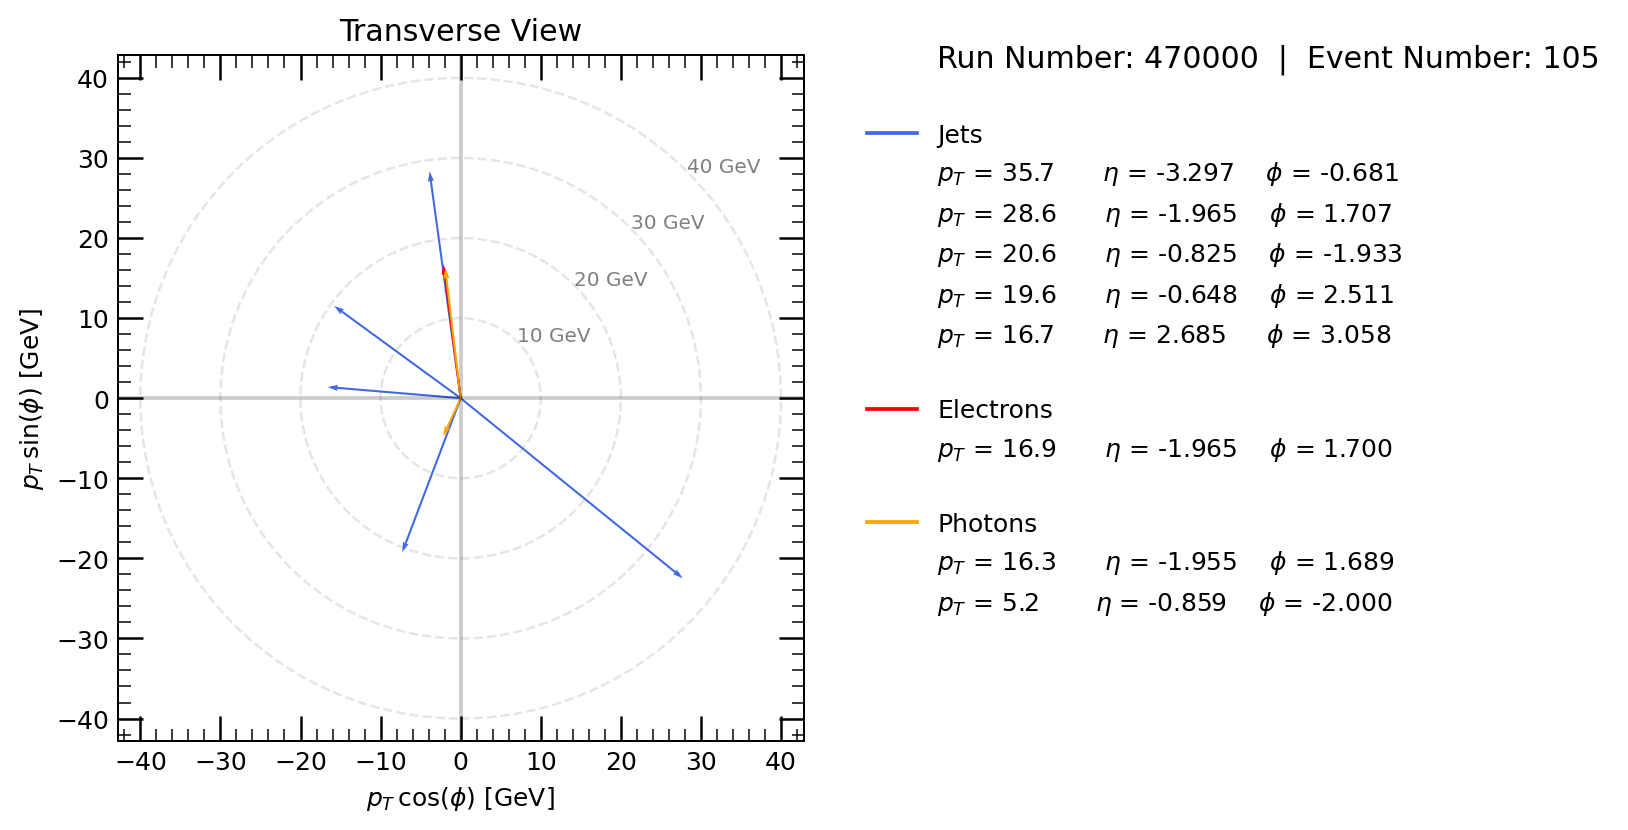

In [38]:
fix, ax = plot_event_2D(hlt_df_no_dupl['HNLeemu'], 'HNLeemu', event_idx=101)

In [39]:
print_event_ordered(hlt_df_afterOR['HNLeemu'], tag='HNLeemu', event_idx=101)

Selected by event_idx = 101
Run Number   = 470000
Event Number = 105

Dataset HNLeemu, Event 101:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    35.7     -3.297     -0.681
j1                    19.6     -0.648      2.511
j2                    16.7      2.685      3.058
j3                     0.0      0.000      0.000
j4                     0.0      0.000      0.000
j5                     0.0      0.000      0.000
e0                    16.9     -1.965      1.700
e1                     0.0      0.000      0.000
e2                     0.0      0.000      0.000
mu0                    0.0      0.000      0.000
mu1                    0.0      0.000      0.000
mu2                    0.0      0.000      0.000
ph0                    5.2     -0.859     -2.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.000
MET   

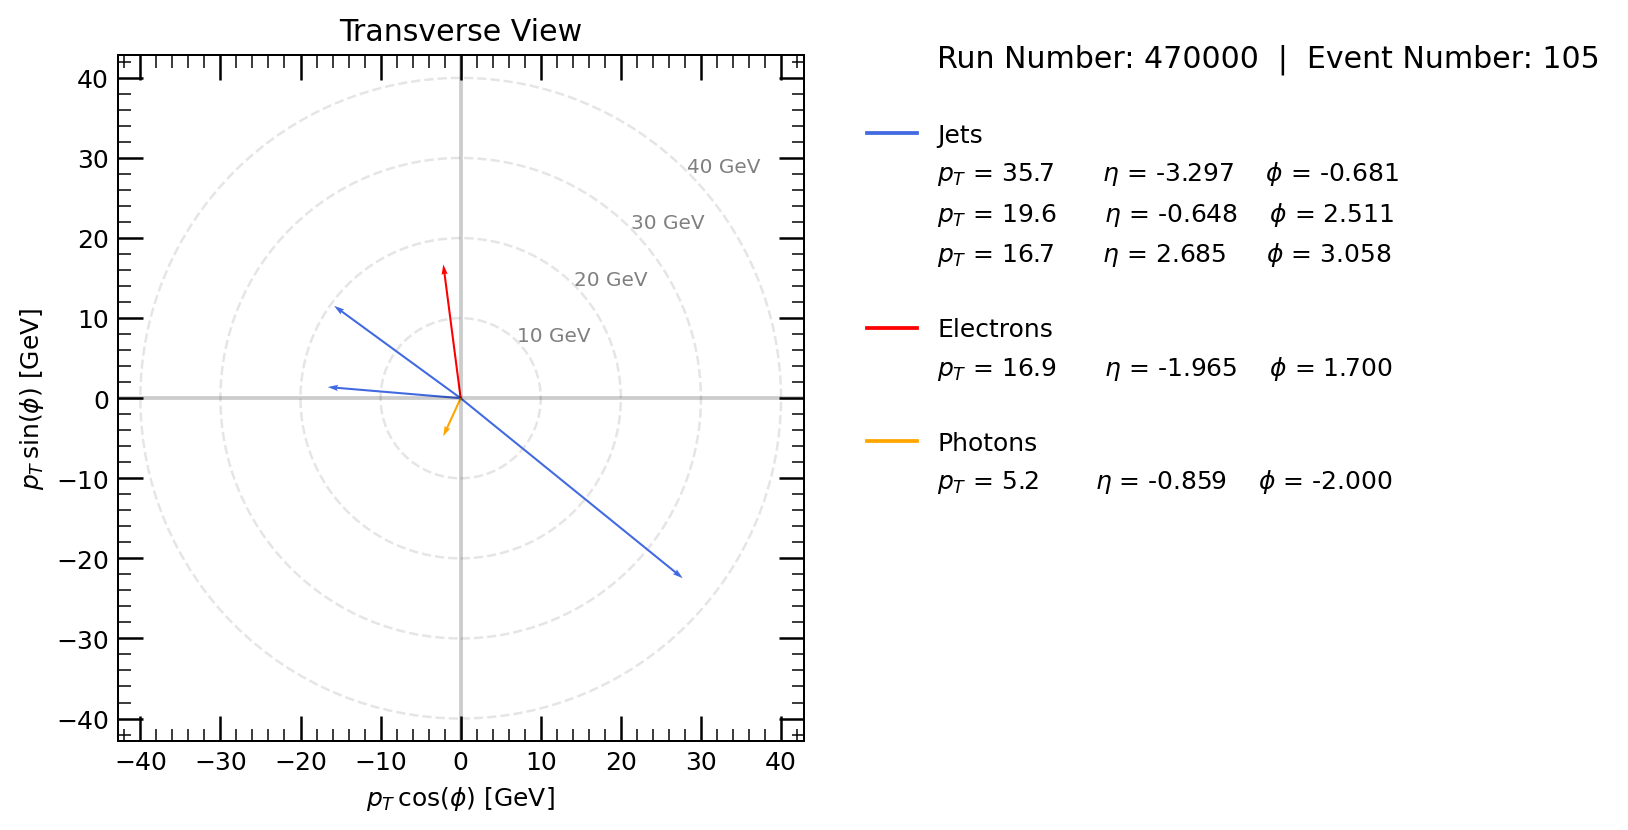

In [40]:
fix, ax = plot_event_2D(hlt_df_afterOR['HNLeemu'], 'HNLeemu', event_idx=101)

In [41]:
hlt_df_afterOR['HtoSUEP'] = overlap_removal(hlt_df_no_dupl_concat, 'HtoSUEP')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HtoSUEP, 100,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                582,127     489,440      92,687       15.9%
e                117,140     111,274       5,866        5.0%
mu                 4,154       2,952       1,202       28.9%
ph                39,792      23,692      16,100       40.5%


In [42]:
hlt_df_afterOR['VBF_H125_a55a55_4b_ctau1_filtered'] = overlap_removal(hlt_df_no_dupl_concat, 'VBF_H125_a55a55_4b_ctau1_filtered')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset VBF_H125_a55a55_4b_ctau1_filtered, 100,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                594,731     421,562     173,169       29.1%
e                201,108     195,960       5,148        2.6%
mu                34,276      21,546      12,730       37.1%
ph                57,340      35,116      22,224       38.8%


In [43]:
hlt_df_afterOR['ggF_H125_a16a16_4b_ctau10_filtered'] = overlap_removal(hlt_df_no_dupl_concat, 'ggF_H125_a16a16_4b_ctau10_filtered')

Processing event 1 / 10,000 ...

Dataset ggF_H125_a16a16_4b_ctau10_filtered, 10,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                 59,220      39,358      19,862       33.5%
e                 20,825      20,577         248        1.2%
mu                 4,148       2,589       1,559       37.6%
ph                 5,496       4,156       1,340       24.4%


In [44]:
hlt_df_afterOR['hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'] = overlap_removal(hlt_df_no_dupl_concat, 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1')

Processing event 1 / 50,000 ...
Processing event 20,001 / 50,000 ...
Processing event 40,001 / 50,000 ...

Dataset hh_bbbb_vbf_novhh_5fs_l1cvv1cv1, 50,000 events total

Object            Initial    Surviving      Removed    % Removed
----------------------------------------------------------------------
j                299,333     193,201     106,132       35.5%
e                111,207     110,082       1,125        1.0%
mu                23,581      14,002       9,579       40.6%
ph                31,363      20,947      10,416       33.2%


In [45]:
hlt_df_afterOR['EB_test'] = overlap_removal(hlt_df_no_dupl_concat, 'EB_test')

Processing event 1 / 1,017,586 ...
Processing event 20,001 / 1,017,586 ...
Processing event 40,001 / 1,017,586 ...
Processing event 60,001 / 1,017,586 ...
Processing event 80,001 / 1,017,586 ...
Processing event 100,001 / 1,017,586 ...
Processing event 120,001 / 1,017,586 ...
Processing event 140,001 / 1,017,586 ...
Processing event 160,001 / 1,017,586 ...
Processing event 180,001 / 1,017,586 ...
Processing event 200,001 / 1,017,586 ...
Processing event 220,001 / 1,017,586 ...
Processing event 240,001 / 1,017,586 ...
Processing event 260,001 / 1,017,586 ...
Processing event 280,001 / 1,017,586 ...
Processing event 300,001 / 1,017,586 ...
Processing event 320,001 / 1,017,586 ...
Processing event 340,001 / 1,017,586 ...
Processing event 360,001 / 1,017,586 ...
Processing event 380,001 / 1,017,586 ...
Processing event 400,001 / 1,017,586 ...
Processing event 420,001 / 1,017,586 ...
Processing event 440,001 / 1,017,586 ...
Processing event 460,001 / 1,017,586 ...
Processing event 480,001 /

In [46]:
order = [
    'EB_test',
    'HAHMggf',
    'HNLeemu',
    'HtoSUEP',
    'VBF_H125_a55a55_4b_ctau1_filtered',
    'Znunu',
    'ggF_H125_a16a16_4b_ctau10_filtered',
    'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'
]

hlt_df_afterOR_concat = pd.concat(
    [hlt_df_afterOR[tag] for tag in order],
    axis=0
)

hlt_df_afterOR_concat.index = hlt_df.index

In [47]:
def plot_obj_mult(df_init, df_afterDupliR, df_afterOR, tag):
    """
    Plot total object multiplicities (jets, electrons, muons, photons)
    for a given tag, comparing:
        - raw events
        - after duplicate removal
        - after OR

    All three dataframes are internally restricted to rows with df['target'] == tag,
    so the counts are directly comparable to remove_duplicates_per_event(tag).
    """
    # -------------------------------------------------
    # Object types: key = prefix, value = highest index
    # (inclusive; j: j0..j5 → 6 jet slots, etc.)
    # -------------------------------------------------
    objects = {
        "j": 5,    # jets:     j0..j5
        "e": 2,    # electrons: e0..e2
        "mu": 2,   # muons:    mu0..mu2
        "ph": 2    # photons:  ph0..ph2
    }
    labels = ["Jets", "Electrons", "Muons", "Photons"]

    # -------------------------------------------------
    # Restrict all DFs to the same tag
    # -------------------------------------------------
    if "target" not in df_init.columns:
        raise KeyError("df_init must contain a 'target' column for tag filtering.")

    df_raw = df_init[df_init["target"] == tag].copy()

    # For the processed dataframes, filter by tag *if* the column exists.
    # This keeps it safe both for per-tag DFs and concatenated DFs.
    if "target" in df_afterDupliR.columns:
        df_dupl = df_afterDupliR[df_afterDupliR["target"] == tag].copy()
    else:
        df_dupl = df_afterDupliR.copy()

    if "target" in df_afterOR.columns:
        df_or = df_afterOR[df_afterOR["target"] == tag].copy()
    else:
        df_or = df_afterOR.copy()

    # -------------------------------------------------
    # Helper: count active objects (non-zero (pt,eta,phi))
    # -------------------------------------------------
    def count_active_objects(df, prefix, max_idx):
        total = 0
        for i in range(max_idx + 1):
            pt_col  = f"{prefix}{i}pt"
            eta_col = f"{prefix}{i}eta"
            phi_col = f"{prefix}{i}phi"

            # If any column is missing, skip that slot gracefully
            if pt_col not in df.columns or eta_col not in df.columns or phi_col not in df.columns:
                continue

            arr = df[[pt_col, eta_col, phi_col]].to_numpy()  # shape (N, 3)
            # active if at least one component is non-zero
            active_mask = np.any(arr != 0.0, axis=1)
            total += np.count_nonzero(active_mask)
        return total

    # -------------------------------------------------
    # Compute totals per object type
    # -------------------------------------------------
    totals_raw   = []
    totals_dupl  = []
    totals_or    = []

    for prefix, max_idx in objects.items():
        totals_raw.append(  count_active_objects(df_raw,  prefix, max_idx) )
        totals_dupl.append( count_active_objects(df_dupl, prefix, max_idx) )
        totals_or.append(   count_active_objects(df_or,   prefix, max_idx) )

    totals_raw   = np.array(totals_raw)
    totals_dupl  = np.array(totals_dupl)
    totals_or    = np.array(totals_or)

    # -------------------------------------------------
    # Plot
    # -------------------------------------------------
    x = np.arange(len(objects))
    width = 0.25

    fig, ax = plt.subplots(figsize=(8, 5),dpi=120)

    ax.bar(x - width, totals_raw,  width=width, label="Raw", color='#0072B2')
    ax.bar(x,         totals_dupl, width=width, label="After duplicate removal", color='#009E73')
    ax.bar(x + width, totals_or,   width=width, label="After overlap removal", color='#56B4E9')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)

    # Remove minor x ticks (in case rcParams enable them globally)
    ax.tick_params(axis="x", which="minor", bottom=False, top=False)

    ax.set_ylabel("Total active objects", fontsize=14)
    ax.set_title(f"Object multiplicity – tag: {tag}", fontsize=16)

    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

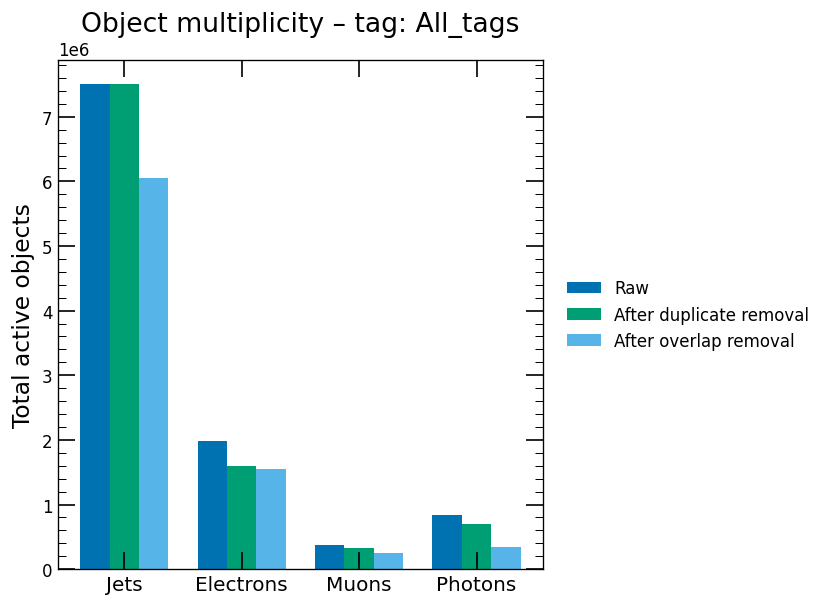

In [ ]:
# Identify signal tags (all except 'EB_test')
signal_tags = [tag for tag in hlt_data_all_tags]

# Create combined dataframes for signals at each stage
# Raw signals
raw_signals_df = pd.concat([hlt_df[hlt_df['target'] == tag] for tag in signal_tags], ignore_index=True)
raw_signals_df['target'] = 'All_tags'

# Signals after duplicate removal
no_dupl_signals_df = pd.concat([hlt_df_no_dupl[tag] for tag in signal_tags], ignore_index=True)
no_dupl_signals_df['target'] = 'All_tags'

# Signals after overlap removal
after_or_signals_df = pd.concat([hlt_df_afterOR[tag] for tag in signal_tags], ignore_index=True)
after_or_signals_df['target'] = 'All_tags'

# Plot for all signals combined
plot_obj_mult(raw_signals_df, no_dupl_signals_df, after_or_signals_df, tag='All_tags')

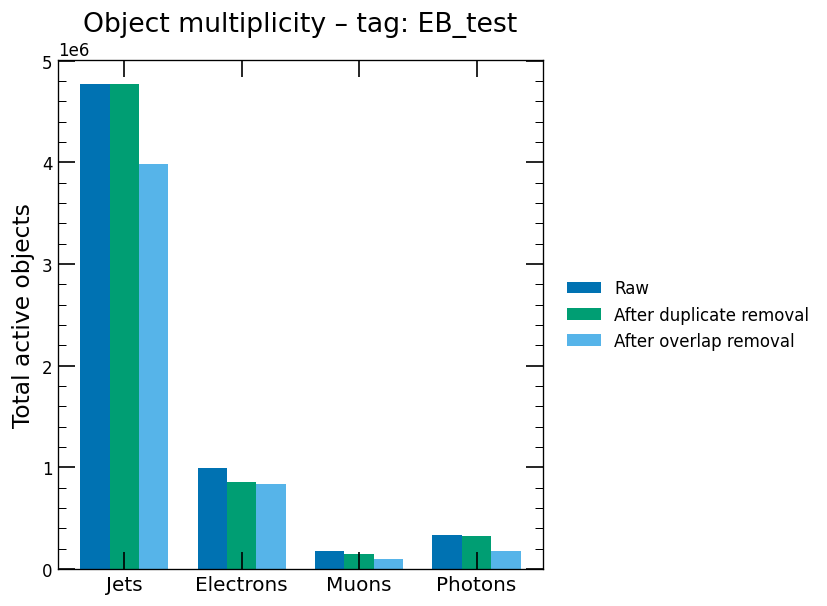

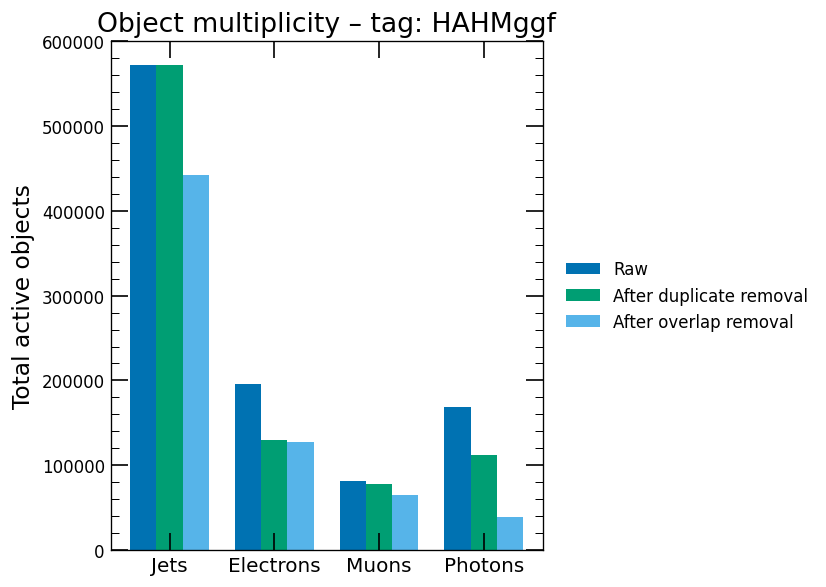

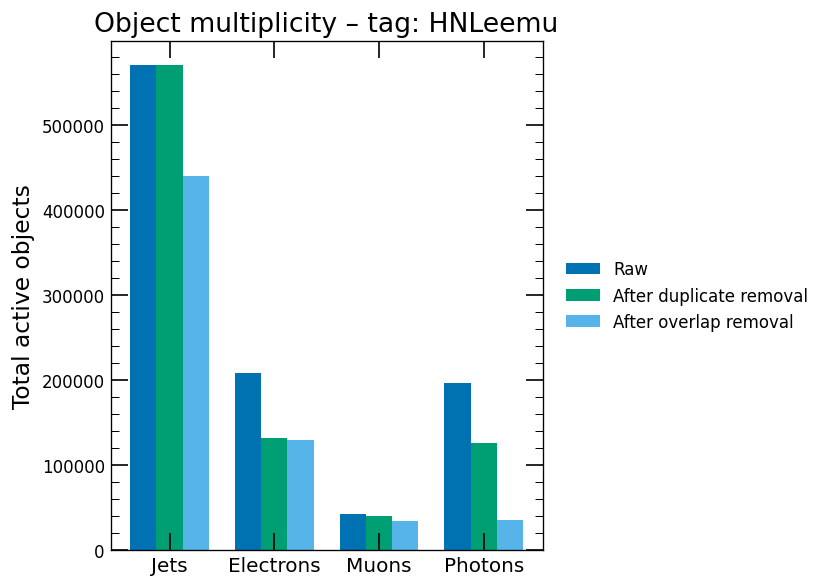

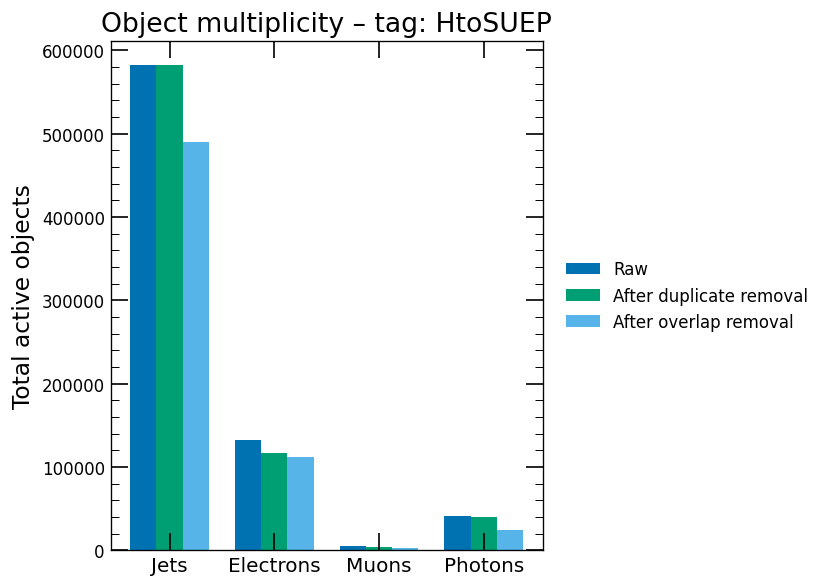

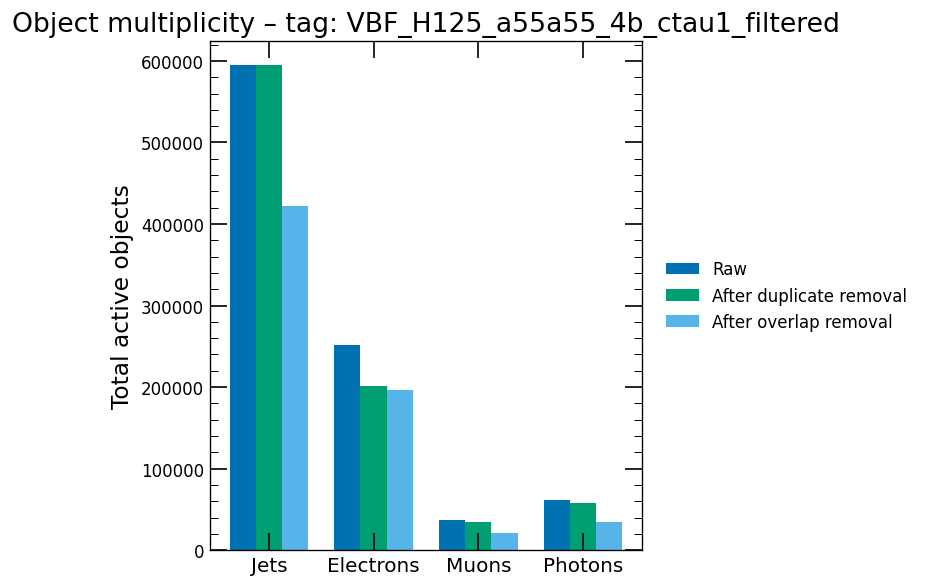

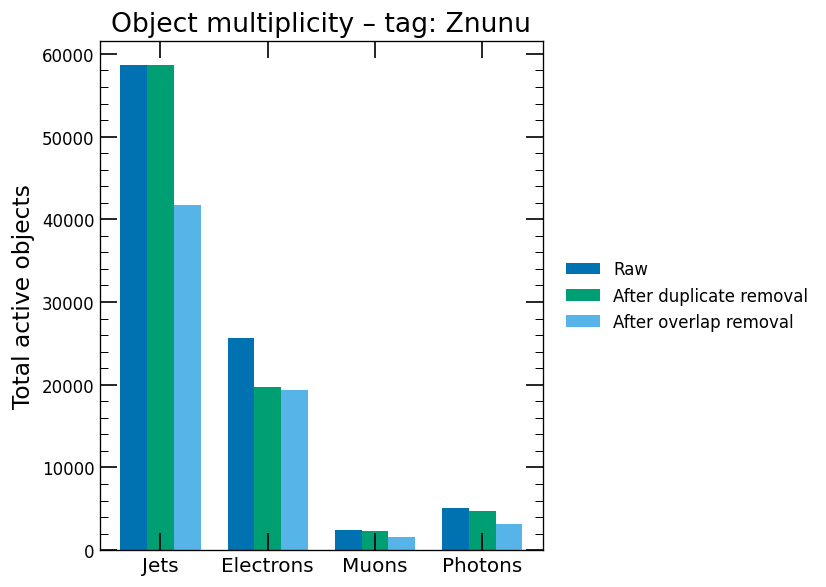

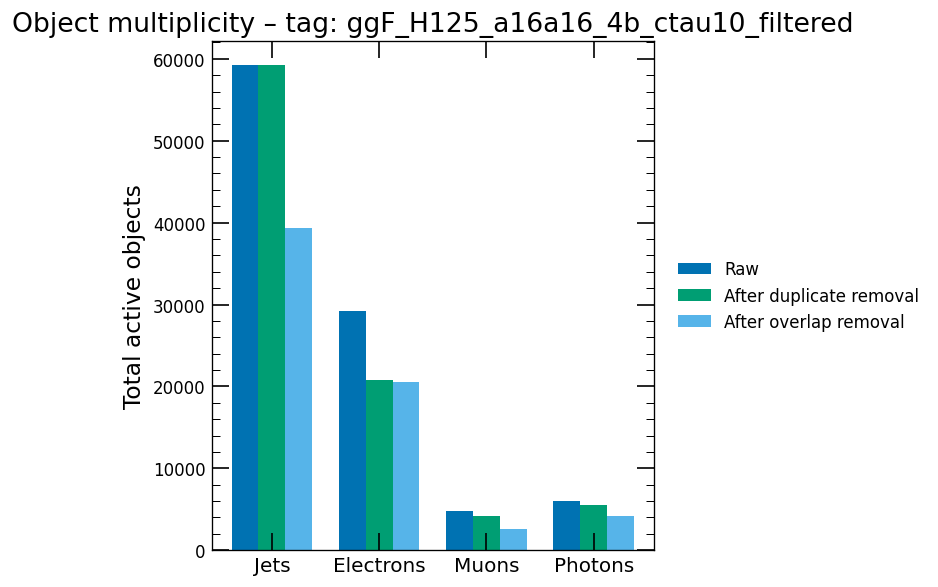

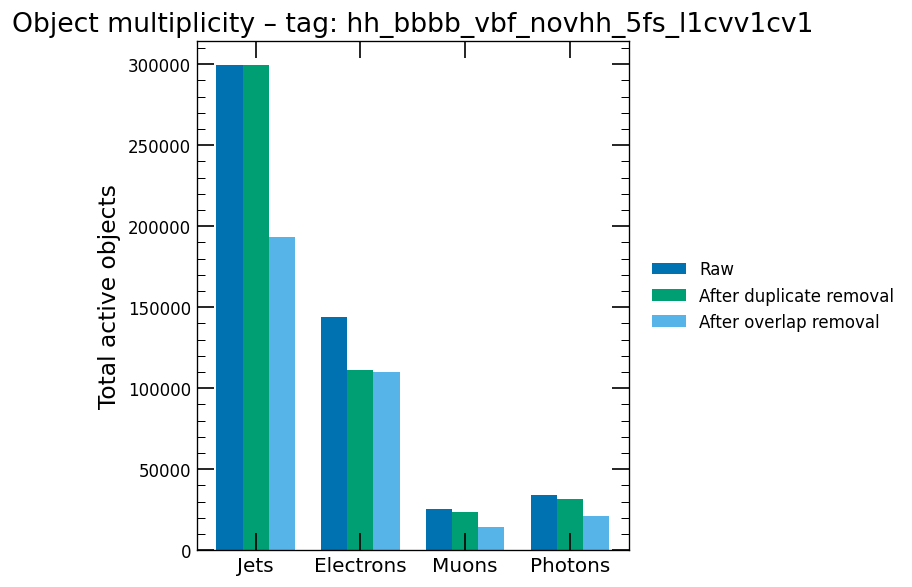

In [49]:
for tag in hlt_data_all_tags:
    if tag == 'All_tags':  # Skip the combined 'All_tags' if it exists in the list
        continue
    plot_obj_mult(hlt_df, hlt_df_no_dupl[tag], hlt_df_afterOR[tag], tag)

In [ ]:
print("hlt_df:", len(hlt_df))
print("no_dupl EB_test:", len(hlt_df_no_dupl['EB_test']))
print("afterOR EB_test:", len(hlt_df_afterOR['EB_test']))

hlt_df: 1487586
no_dupl EB_test: 1017586
afterOR EB_test: 1017586


In [ ]:
cols_j = [f"j{i}pt" for i in range(6)]
print("Raw jets:", (hlt_df[cols_j] > 0.001).sum().sum())
print("After dupl:", (hlt_df_no_dupl['EB_test'][cols_j] > 0.001).sum().sum())
print("After OR:", (hlt_df_afterOR['EB_test'][cols_j] > 0.001).sum().sum())

Raw jets: 7502604
After dupl: 4766870
After OR: 3984096


In [ ]:
def make_balanced_samples(filtered_df):

    # Identify background and signals
    bkg = filtered_df[filtered_df["target"] == "EB_test"].copy()
    sig = filtered_df[filtered_df["target"] != "EB_test"].copy()

    results = {}

    # -----------------------------------------------------------
    # 1. Equal TOTAL number of signals (all combined) and background
    # -----------------------------------------------------------

    n_sig_total = len(sig)

    bkg_sample_total = bkg.sample(
        n=n_sig_total,
        weights=bkg["weight"],
        replace=False
    )

    results["all_signals"] = pd.concat(
        [sig, bkg_sample_total],
        ignore_index=True
    )

    # -----------------------------------------------------------
    # 2. Equal number of signal and background FOR EACH SIGNAL CLASS
    # -----------------------------------------------------------

    for cls, sig_cls_df in sig.groupby("target"):

        n_cls = len(sig_cls_df)

        bkg_sample = bkg.sample(
            n=n_cls,
            weights=bkg["weight"],
            replace=False
        )

        # Store each class with its own key (flat dictionary)
        results[cls] = pd.concat(
            [sig_cls_df, bkg_sample],
            ignore_index=True
        )

    return results


In [ ]:
hlt_df_filtered_pt_cut = {}
pt_threshold_for_objects = 5.0 # This threshold is now specific to the object pT condition

# Define prefixes for objects whose pT needs to be checked
object_prefixes = ['j', 'e', 'mu', 'ph']

for tag, df_original in hlt_df_afterOR.items(): # Renamed to df_original for clarity
    print(f"Filtering dataset: {tag}")

    # Create a list of all object pT columns to check (excluding METpt)
    pt_columns_for_objects = []
    for prefix in object_prefixes:
        for col in df_original.columns:
            if col.startswith(prefix) and col.endswith('pt'):
                pt_columns_for_objects.append(col)

    # Handle cases where no object pT columns are found (though unlikely with this dataset)
    actual_pt_cols_for_objects = [col for col in pt_columns_for_objects if col in df_original.columns]

    if not actual_pt_cols_for_objects:
        # If no object pT columns, then no 'pt_violation' can occur from these objects
        has_any_obj_pt_violation = pd.Series(False, index=df_original.index)
    else:
        # Create a mask where individual object pT is > 0 and < pt_threshold_for_objects
        individual_pt_violation_mask = (df_original[actual_pt_cols_for_objects] > 0) & \
                                       (df_original[actual_pt_cols_for_objects] < pt_threshold_for_objects)
        # Check if ANY of these individual object pT violations are True for each event
        has_any_obj_pt_violation = individual_pt_violation_mask.any(axis=1)

    # Define the final keep mask based on the complex logic:
    # An event is kept if:
    # 1. METpt > 0
    # OR
    # 2. (METpt is NOT -999.00 AND has_any_obj_pt_violation is False)
    #    This covers cases where (METpt == 0 AND no pt_violation) OR (METpt < 0 but not -999 AND no pt_violation)
    final_keep_mask = (df_original['METpt'] > 0) | \
                      ((df_original['METpt'] != -999.00) & (~has_any_obj_pt_violation))

    filtered_df = df_original[final_keep_mask].copy()
    print(f"  Original events: {len(df_original):,}, Filtered events: {len(filtered_df):,}")
    hlt_df_filtered_pt_cut[tag] = filtered_df

print("\nFiltered DataFrames created in 'hlt_df_filtered_pt_cut' with updated logic.")

Filtering dataset: Znunu
  Original events: 10,000, Filtered events: 9,225
Filtering dataset: HAHMggf
  Original events: 100,000, Filtered events: 78,812
Filtering dataset: HNLeemu
  Original events: 100,000, Filtered events: 63,449
Filtering dataset: HtoSUEP
  Original events: 100,000, Filtered events: 32,428
Filtering dataset: VBF_H125_a55a55_4b_ctau1_filtered
  Original events: 100,000, Filtered events: 84,474
Filtering dataset: ggF_H125_a16a16_4b_ctau10_filtered
  Original events: 10,000, Filtered events: 8,320
Filtering dataset: hh_bbbb_vbf_novhh_5fs_l1cvv1cv1
  Original events: 50,000, Filtered events: 40,949
Filtering dataset: EB_test
  Original events: 1,017,586, Filtered events: 992,887

Filtered DataFrames created in 'hlt_df_filtered_pt_cut' with updated logic.


In [ ]:
print("\nEvent Counts Comparison (Original vs. Filtered by 5 GeV pT cut):\n")

# Column widths (tweak if needed)
col1 = 40   # dataset name
col2 = 18   # original events
col3 = 18   # filtered events
col4 = 12   # % retained

# Header
print(f"{'Dataset':<{col1}}{'Original Events':>{col2}}{'Filtered Events':>{col3}}{'% Retained':>{col4}}")
print("-" * (col1 + col2 + col3 + col4))

# Rows
for tag in hlt_df_no_dupl.keys():
    original_count = len(hlt_df_no_dupl[tag])
    filtered_count = len(hlt_df_filtered_pt_cut[tag])
    pct = (filtered_count / original_count * 100) if original_count else 0

    print(
        f"{tag:<{col1}}"
        f"{original_count:>{col2},}"
        f"{filtered_count:>{col3},}"
        f"{pct:>{col4}.2f}%"
    )



Event Counts Comparison (Original vs. Filtered by 5 GeV pT cut):

Dataset                                    Original Events   Filtered Events  % Retained
----------------------------------------------------------------------------------------
HAHMggf                                            100,000            78,812       78.81%
HNLeemu                                            100,000            63,449       63.45%
HtoSUEP                                            100,000            32,428       32.43%
VBF_H125_a55a55_4b_ctau1_filtered                  100,000            84,474       84.47%
Znunu                                               10,000             9,225       92.25%
ggF_H125_a16a16_4b_ctau10_filtered                  10,000             8,320       83.20%
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1                     50,000            40,949       81.90%
EB_test                                          1,017,586           992,887       97.57%


In [ ]:
# Combine all filtered dataframes into a single dataframe for easier plotting
filtered_df = pd.concat(hlt_df_filtered_pt_cut.values(), ignore_index=True)

In [ ]:
ML_dict = make_balanced_samples(filtered_df)

In [ ]:
ML_dict.keys()

dict_keys(['all_signals', 'HAHMggf', 'HNLeemu', 'HtoSUEP', 'VBF_H125_a55a55_4b_ctau1_filtered', 'Znunu', 'ggF_H125_a16a16_4b_ctau10_filtered', 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'])

In [ ]:
# import pickle

# with open("/content/drive/MyDrive/Datasets/balanced_dfs_no_dup_OR.pkl", "wb") as f:
#     pickle.dump(ML_dict, f)